In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
sns.set(rc = {'figure.figsize':(10, 6)})
pd.set_option("precision", 3)

In [2]:
folder = "/home/jarobyte/scratch/guemes/icdar/sl/baseline/experiments/"

In [3]:
files = os.listdir(folder)
len(files)

25

In [4]:
logs = pd.concat([pd.read_csv(folder + f) 
                       for f in tqdm(os.listdir(folder))])\
.assign(dropout = lambda df: df.dropout.round(2))
print(logs.shape)
logs.head()

  0%|          | 0/25 [00:00<?, ?it/s]

(1378, 21)


,epoch,train_loss,train_error_rate,dev_loss,dev_error_rate,training_minutes,learning_rate,weight_decay,model,max_sequence_length,...,feedforward_dimension,encoder_layers,decoder_layers,attention_heads,activation,dropout,parameters,encoder_tokens,decoder_tokens,experiment_id
0,1,1.216,35.390,0.113,6.038,1.808,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.2,3815554,130,130,22698318_10
1,2,0.343,12.343,0.081,5.187,3.644,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.2,3815554,130,130,22698318_10
2,3,0.300,11.509,0.067,4.841,5.480,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.2,3815554,130,130,22698318_10
3,4,0.274,10.963,0.060,4.680,7.311,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.2,3815554,130,130,22698318_10
4,5,0.256,10.562,0.054,4.497,9.151,1.000e-04,1.000e-04,Transformer,110,...,1024,2,2,8,relu,0.2,3815554,130,130,22698318_10


In [5]:
experiments = logs\
.assign(fit = lambda df: df.apply(lambda r: {k:r[k] for k in ["train_loss", 
                                                              "dev_loss", 
                                                              "epoch"]}, 
                                  axis = 1))\
.groupby("experiment_id")\
.agg({"fit":(lambda x: min(x, key = lambda y: y["dev_loss"])),
      "parameters":max, 
      "dropout":max,
      "weight_decay":max,
      "embedding_dimension":max,
      "encoder_layers":max,
      "training_minutes":max})\
.assign(parameters = lambda df: df.parameters / 10**6, 
        train_loss = lambda df: df.fit.map(lambda x: x["train_loss"]),
        dev_loss = lambda df: df.fit.map(lambda x: x["dev_loss"]),
        epoch = lambda df: df.fit.map(lambda x: x["epoch"]))\
.drop(columns = "fit")
experiments.head(10)

,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
experiment_id,,,,,,,,,
22698318_1,3.816,0.2,1.000e-02,256,2,103.651,2.290,2.308,50
22698318_10,3.816,0.2,1.000e-04,256,2,106.697,0.157,0.035,15
22698318_11,3.816,0.1,1.000e-02,256,2,103.125,2.307,2.333,47
22698318_12,3.816,0.4,1.000e-02,256,2,105.643,2.363,2.390,53
22698318_2,3.816,0.4,1.000e-04,256,2,103.586,0.213,0.046,29
22698318_3,3.816,0.2,1.000e-02,256,2,106.076,2.357,2.388,51
22698318_4,3.816,0.5,1.000e-02,256,2,103.139,2.365,2.394,50
22698318_5,3.816,0.2,1.000e-03,256,2,103.799,0.323,0.081,55
22698318_6,3.816,0.2,1.000e-02,256,2,104.573,2.307,2.331,55


# evaluation

In [6]:
evaluation_folder = "/home/jarobyte/scratch/guemes/icdar/sl/baseline/evaluation/"

In [7]:
evaluation_files = os.listdir(evaluation_folder)
len(evaluation_files)

25

In [8]:
evaluation = pd.concat([pd.read_csv(evaluation_folder + f) 
                       for f in tqdm(os.listdir(evaluation_folder))])
print(evaluation.shape)
evaluation.head()

  0%|          | 0/25 [00:00<?, ?it/s]

(250, 9)


,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting
0,22717049_10,-94.093,disjoint,greedy,100,2.543,1.251,2.429,NaN
1,22717049_10,-197.534,disjoint,greedy,50,1.250,1.251,3.723,NaN
2,22717049_10,-433.745,disjoint,beam,100,5.905,1.251,6.679,NaN
3,22717049_10,-215.325,disjoint,beam,50,4.185,1.251,3.946,NaN
4,22717049_10,-8.049,sliding,greedy,50,22.358,1.251,1.352,uniform


In [9]:
results = evaluation.merge(experiments, right_index = True, left_on = "experiment_id")\
.sort_values("improvement", ascending = False)
results.head()

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
9,22717049_9,7.279,sliding,beam,50,184.965,1.251,1.160,bell,3.816,0.0,0.000e+00,256,2,97.239,0.212,0.072,3
9,22698318_10,6.462,sliding,beam,50,209.133,1.251,1.170,bell,3.816,0.2,1.000e-04,256,2,106.697,0.157,0.035,15
8,22698318_10,6.462,sliding,beam,50,213.131,1.251,1.170,triangle,3.816,0.2,1.000e-04,256,2,106.697,0.157,0.035,15
8,22717049_9,6.172,sliding,beam,50,184.397,1.251,1.174,triangle,3.816,0.0,0.000e+00,256,2,97.239,0.212,0.072,3
5,22698318_10,4.366,sliding,greedy,50,21.979,1.251,1.197,triangle,3.816,0.2,1.000e-04,256,2,106.697,0.157,0.035,15


<AxesSubplot:>

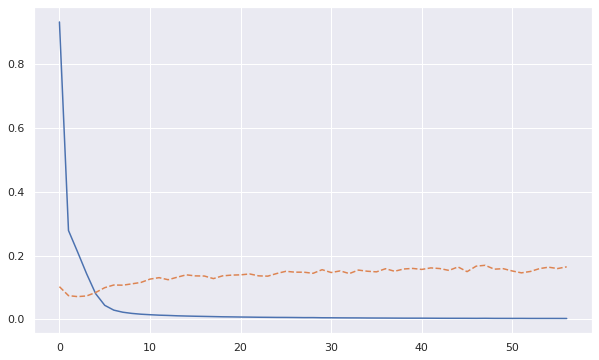

In [10]:
logs.query("experiment_id == '22717049_9'").train_loss.plot()
logs.query("experiment_id == '22717049_9'").dev_loss.plot(ls = "--")

In [11]:
results.query("experiment_id == '22698318_10'")\
[["experiment_id", "window", "window_size", "decoding", "weighting", "improvement"]]\
.sort_values(["window", "window_size", "decoding", "weighting"])\
.pivot(index = "experiment_id", 
       values = "improvement", 
       columns = ["window", "window_size", "decoding", "weighting"])

window        disjoint                           sliding                   \
window_size        50               100              50                     
decoding          beam   greedy    beam   greedy    beam                    
weighting          NaN      NaN     NaN      NaN    bell triangle uniform   
experiment_id                                                               
22698318_10   -118.832 -131.118 -63.635 -215.867   6.462    6.462   2.148   

window                                 
window_size                            
decoding      greedy                   
weighting       bell triangle uniform  
experiment_id                          
22698318_10    4.366    4.366   1.088